In [4]:
import utils
import random

from factscore.retrieval import DocDB

db = DocDB(db_path=".cache/factscore/enwiki-20230401.db")

def check_db(ent):
    try:
        db.get_text_from_title(ent)
        return True
    except AssertionError:
        return False

def append_unique_elements_with_check(list_a, list_b, n, check_func):
    # Convert lists to sets for faster lookup
    set_a = set(list_a)
    set_b = set(list_b)

    # Find unique elements in list_b that satisfy the check function
    unique_elements = [elem for elem in set_b - set_a if check_func(elem)]

    # Randomly pick n unique elements
    if len(unique_elements) >= n:
        new_elements = random.sample(unique_elements, n)
    else:
        new_elements = unique_elements

    # Append new elements to list_a
    list_a.extend(new_elements)
    return list_a

named_entities = utils.read_file_lines("./all_names.txt")
chosen_entities = utils.read_file_lines("./chosen_names.txt")

new_chosen_names = append_unique_elements_with_check(chosen_entities, named_entities, 355 - len(chosen_entities), check_db)

In [6]:
utils.write_list_to_file("./chosen_names.txt", new_chosen_names)

In [15]:
import utils

def calculate_average_factscore(dict_list, names=None):
    total_factscore = 0
    count = 0

    for d in dict_list:
        if "factscore" in d:
            if names is not None:
                if d["topic"] in names:
                    total_factscore += d["factscore"]
                    count += 1    
            else:
                total_factscore += d["factscore"]
                count += 1

    if count == 0:
        return None
    else:
        return total_factscore / count

def calculate_average_facts(dict_list, names=None):
    all_facts = 0
    for d in dict_list:
        total_facts = 0
        if names is not None:
            if d["topic"] in names:
                for ann in d["annotations"]:
                    total_facts += len(ann["model-atomic-facts"])
                all_facts += total_facts
        else:
            for ann in d["annotations"]:
                total_facts += len(ann["model-atomic-facts"])
            all_facts += total_facts
    
    return all_facts / len(dict_list)

def calculate_average_true_false_facts(dict_list, names=None):
    false_facts = 0
    true_facts = 0
    true_per = 0.0
    for d in dict_list:
        t = 0
        f = 0
        if names is not None:
            if d["topic"] in names:
                for ann in d["annotations"]:
                    for atom in ann["model-atomic-facts"]:
                        if atom["is_supported"]["is_supported"]:
                            t += 1
                        else:
                            f += 1
            true_facts += t
            false_facts += f
            true_per += t / (t+f)
        else:
            for ann in d["annotations"]:
                for atom in ann["model-atomic-facts"]:
                    if atom["is_supported"]["is_supported"]:
                        t += 1
                    else:
                        f += 1
            true_facts += t
            false_facts += f
            if (t+f) != 0:
                true_per += t / (t+f)

    return true_facts / len(dict_list), false_facts / len(dict_list), true_facts / (true_facts + false_facts)

In [60]:
from glob import glob

base_test_results = {}
infamous_test_results = {}
for fpath in glob("./data/test_zeroshot/*.jsonl"):
    fname = fpath.split("/")[-1]
    model = fname.split("-test")[0]

    test_data = utils.read_jsonl_file(fpath, remove_annotate=False)
    true_facts, false_facts, true_per = calculate_average_true_false_facts(test_data)
    if "infamous" in fpath:
        infamous_model = model.replace("infamous-", "")
        infamous_test_results[infamous_model] = {
            "avg_factscore": calculate_average_factscore(test_data),
            "avg_num_facts": calculate_average_facts(test_data),
            "avg_correct_facts": true_facts,
            "avg_incorrect_facts": false_facts,
            "avg_correct_percentage": true_per
        }
    else:
        base_test_results[model] = {
            "avg_factscore": calculate_average_factscore(test_data),
            "avg_num_facts": calculate_average_facts(test_data),
            "avg_correct_facts": true_facts,
            "avg_incorrect_facts": false_facts,
            "avg_correct_percentage": true_per
        }

In [61]:
import json

with open("./data/test_zeroshot/base_test_results.json", "w") as file:
    json.dump(base_test_results, file, indent=4)

with open("./data/test_zeroshot/infamous_test_results.json", "w") as file:
    json.dump(infamous_test_results, file, indent=4)

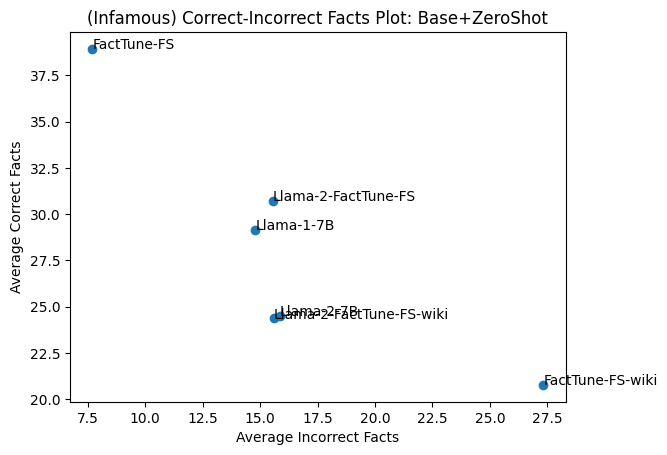

In [65]:
import json
import matplotlib.pyplot as plt

# Load the JSON data
with open('./data/test_zeroshot/infamous_test_results.json', 'r') as f:
    data = json.load(f)

# Extract the required values from the JSON data
x_values = []
y_values = []
labels = []

for key, value in data.items():
    x_values.append(value['avg_incorrect_facts'])
    y_values.append(value['avg_correct_facts'])
    labels.append(key)

# Create the plot
fig, ax = plt.subplots()
ax.scatter(x_values, y_values)

# Add labels and title
ax.set_xlabel('Average Incorrect Facts')
ax.set_ylabel('Average Correct Facts')
ax.set_title('(Infamous) Correct-Incorrect Facts Plot: Base+ZeroShot')

# Add data labels
for i, label in enumerate(labels):
    ax.annotate(label, (x_values[i], y_values[i]))

# Show the plot
plt.show()

In [29]:
train_names = utils.read_file_lines("./infamous_train.txt")
phi3_wiki = utils.read_jsonl_file("./data/infamous/infamous-factscore-wiki.jsonl", remove_annotate=False)
based = utils.read_jsonl_file("./data/infamous/infamous-factscore.jsonl", remove_annotate=False)
# free = utils.read_jsonl_file_all("./data/reference_free/Llama-1-7B-facts-questions-factscore-Hung.jsonl")
# old = utils.read_jsonl_file("./data/infamous/infamous-factscore.jsonl", remove_annotate=False)

print("phi3_wiki", calculate_average_factscore(phi3_wiki, names=train_names))
print("based", calculate_average_factscore(based, names=train_names))
# print("free", calculate_average_factscore(free, names=train_names))
# print("old", calculate_average_factscore(old))

1480
phi3_wiki 0.93845548994859
2960
based 0.4051755796044512


In [7]:
based_train = utils.read_jsonl_file_all("./data/Llama-1-7B-pref-based-train.jsonl")

In [9]:
prompt_train = [b["prompt"] for b in based_train]
prompt_train = list(set(prompt_train))

296

In [16]:
from operator import itemgetter

facts = utils.read_jsonl_file_all("./data/Llama-1-7B-facts.jsonl")
sorted_facts = sorted(facts, key=itemgetter("topic", "num_response"))
sorted_free = sorted(free, key=itemgetter("topic", "num_response"))

for idx, s in enumerate(sorted_free):
    f = sorted_facts[idx]
    if s["topic"] == f["topic"] and s["num_response"] == f["num_response"]:
        s["input"] = f["input"]
        s["output"] = f["output"]
    else:
        raise ValueError()

In [17]:
free_train, free_test = [], []

for s in sorted_free:
    if s["input"] in prompt_train:
        free_train.append(s)
    else:
        free_test.append(s)

In [23]:
free_train_batch = utils.split_list_into_batches(free_train, 10)

In [17]:
import utils
from operator import itemgetter

def remove_duplicates(dict_list):
    unique_dicts = []
    seen = []  # Use a list instead of a set

    for d in dict_list:
        t = tuple(d.items())  # Convert to tuple of (key, value) pairs
        if t not in seen:
            seen.append(t)
            unique_dicts.append(d)

    return unique_dicts

def dict_key(d, keys):
    """
    Returns a tuple of values corresponding to the given keys in the dictionary.
    This tuple can be used as a key for grouping or deduplication purposes.
    """
    return tuple(d[k] for k in keys)

facts = utils.read_jsonl_file_all("./data/test/FactTune-MC-test.jsonl")
sorted_facts = sorted(facts, key=itemgetter("topic", "num_response"))
sorted_facts = remove_duplicates(sorted_facts)
sorted_facts = list({dict_key(d, ["topic", "num_response"]): d for d in sorted_facts}.values())
batches = utils.split_list_into_batches(sorted_facts, 10)
for batch in batches:
    same = check_same_topic(batch)
    if not same:
        print(batch[0]["topic"])
        raise ValueError()

utils.write_jsonl(sorted_facts, "./data/test/FactTune-MC-test.jsonl")

# old_batches = utils.split_list_into_batches(sorted_facts, 10)
# train_data, test_data = utils.random_sample_and_remaining(old_batches, 296)

Data written to ./data/test/FactTune-MC-test.jsonl successfully.


In [1]:
def check_same_topic(dict_list):
    """
    Checks if all dictionaries in a list have the same value for the key "topic".
    Returns True if all dictionaries have the same "topic" value, False otherwise.
    """
    if not dict_list:
        return True  # Return True for an empty list

    first_dict = dict_list[0]
    if "topic" not in first_dict:
        return False  # Return True if "topic" key is not present in any dictionary

    reference_topic = first_dict["topic"]

    for d in dict_list:
        if "topic" not in d or d["topic"] != reference_topic:
            return False

    return True

In [26]:
for batch in free_train_batch:
    same = check_same_topic(batch)
    if not same:
        print(batch[0]["topic"])
        raise ValueError()

In [9]:
from itertools import combinations

def process_pairs(data):
    pairs = []
    for pair in combinations(data, 2):
        if pair[0]["factscore"] != pair[1]["factscore"]:
            pref = {"prompt": pair[0]["input"]}
            if pair[0]["factscore"] > pair[1]["factscore"]:
                pref["chosen"] = pair[0]["output"]
                pref["rejected"] = pair[1]["output"]
            else:
                pref["chosen"] = pair[1]["output"]
                pref["rejected"] = pair[0]["output"]
            pairs.append(pref)
    return pairs

def convert_list_of_dicts_to_dict(list_of_dicts):
    """
    Converts a list of dictionaries with the same keys into a dictionary
    where each key contains a list of values from all dictionaries in the input list.
    """
    result_dict = {}
    keys = list_of_dicts[0].keys()  # Assuming all dictionaries have the same keys

    for key in keys:
        result_dict[key] = [d[key] for d in list_of_dicts]

    return result_dict

In [30]:
old_pref_data = []
for batch in free_train_batch:
    pairs = process_pairs(batch)
    for pair in pairs:
        old_pref_data.append(pair)

In [31]:
import random

from datasets import Dataset

random.shuffle(old_pref_data)
utils.write_jsonl(old_pref_data, "./data/Llama-1-7B-pref-free-train.jsonl")

print(len(old_pref_data))

train = convert_list_of_dicts_to_dict(old_pref_data)
train = Dataset.from_dict(train)

train.save_to_disk("./data/Llama-1-7B-free-train")

Data written to ./data/Llama-1-7B-pref-free-train.jsonl successfully.
13318


Saving the dataset (0/1 shards):   0%|          | 0/13318 [00:00<?, ? examples/s]

In [32]:
# flatten_test = []
# for d in test_data:
#     flatten_test.extend(d)

random.shuffle(free_test)
utils.write_jsonl(free_test, "./data/Llama-1-7B-free-test.jsonl")

Data written to ./data/Llama-1-7B-free-test.jsonl successfully.


## Some Scratch Notes

In [1]:
from mediawiki import MediaWiki

wikipedia = MediaWiki()

In [3]:
import utils, random

infamous_all = utils.read_jsonl_file_all("./data/infamous/infamous-factscore.jsonl")
infamous_test = utils.read_jsonl_file_all("./data/infamous/infamous-based-test.jsonl")

all_names = []
for d in infamous_all:
    if d["topic"] not in all_names:
        all_names.append(d["topic"])
all_names = list(set(all_names))

test_names = []
for d in infamous_test:
    if d["topic"] not in test_names:
        test_names.append(d["topic"])
test_names = list(set(test_names))

In [4]:
train_names = []
for name in all_names:
    if name not in test_names:
        train_names.append(name)

In [7]:
utils.write_list_to_file("infamous_train.txt", train_names)
utils.write_list_to_file("infamous_test.txt", test_names)

In [8]:
from tqdm import tqdm

for t in tqdm(train_names):
    wiki_content = wikipedia.page(t).content
    wiki_content = wiki_content.split("\n\n")[0]
    utils.append_dict_to_jsonl("./data/infamous-train-wiki.jsonl", {t: wiki_content})

  0%|          | 0/296 [00:00<?, ?it/s]

100%|██████████| 296/296 [05:59<00:00,  1.22s/it]


In [11]:
def merge_dicts(list_of_dicts):
    result = {}
    for d in list_of_dicts:
        result.update(d)
    return result

# Example usage
list_of_dicts = [
    {"a": 1, "b": 2},
    {"c": 3, "d": 4},
    {"e": 5, "f": 6}
]

merged_dict = merge_dicts(list_of_dicts)
print(merged_dict)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6}


In [9]:
train_wiki = utils.read_jsonl_file_all("./data/infamous-train-wiki.jsonl")

In [12]:
train_wiki = merge_dicts(train_wiki)

In [13]:
utils.append_dict_to_jsonl("./data/infamous-train-wiki.jsonl", train_wiki)

In [17]:
import utils

chosen = utils.read_jsonl_file_all("./data/infamous/infamous-factscore-wiki.jsonl")
chosen = sorted(chosen, key=itemgetter("topic", "num_response"))
rejected = utils.read_jsonl_file_all("./data/infamous-train-rejected.jsonl")

chosen_batch = utils.split_list_into_batches(chosen, 5)
rejected_batch = utils.split_list_into_batches(rejected, 5)

In [18]:
for batch in chosen_batch:
    same = check_same_topic(batch)
    if not same:
        print(batch[0]["topic"])
        raise ValueError()

for batch in rejected_batch:
    same = check_same_topic(batch)
    if not same:
        print(batch[0]["topic"])
        raise ValueError()

In [19]:
def build_pairs(list_a, list_b):
    pairs = []
    for dict_a in list_a:
        for dict_b in list_b:
            pairs.append((dict_a, dict_b))
    return pairs

pairs = []
for i, batch in enumerate(chosen_batch):
    reject_batch = rejected_batch[i]
    assert len(reject_batch) == len(batch)
    for c in batch:
        for r in reject_batch:
            pair = {
                "prompt": c["input"],
                "chosen": f"\n\n{c['output']}",
                "rejected": f"\n\n{r['output']}",
            }
            pairs.append(pair)
            # utils.append_dict_to_jsonl("./data/Phi3_wiki/Phi3-pref-train.jsonl", pair)


In [20]:
import random
from datasets import Dataset

utils.write_jsonl(pairs, "./data/infamous/infamous-pref-based-train-wiki.jsonl")
random.shuffle(pairs)
train = convert_list_of_dicts_to_dict(pairs)
train = Dataset.from_dict(train)

train.save_to_disk("./data/hf_datasets/infamous-based-train-wiki")

Data written to ./data/infamous/infamous-pref-based-train-wiki.jsonl successfully.


Saving the dataset (0/1 shards):   0%|          | 0/7400 [00:00<?, ? examples/s]

In [3]:
import utils

infamous_all = utils.read_jsonl_file_all("./data/infamous/infamous-factscore.jsonl")
infamous_train_wiki = utils.read_jsonl_file_all("./data/infamous/infamous-factscore-wiki.jsonl")

In [4]:
len(infamous_train_wiki)

1480

In [5]:
from operator import itemgetter

infamous_all = sorted(infamous_all, key=itemgetter("topic", "num_response"))
infamous_train_wiki = sorted(infamous_train_wiki, key=itemgetter("topic", "num_response"))

In [6]:
train_names = utils.read_file_lines("./infamous_train.txt")
infamous_train = []
for d in infamous_all:
    if d["topic"] in train_names:
        infamous_train.append(d)

In [10]:
infamous_train = utils.split_list_into_batches(infamous_train, 10)

In [12]:
infamous_rejected = []
for batch in infamous_train:
    sorted_batch = sorted(batch, key=lambda x: x["factscore"])
    lowest_data = sorted_batch[:5]
    infamous_rejected.extend(lowest_data)

In [14]:
utils.write_jsonl(infamous_rejected, "./data/infamous-train-rejected.jsonl")

Data written to ./data/infamous-train-rejected.jsonl successfully.


In [48]:
import utils

train_names = utils.read_file_lines("./train_names.txt")
based = utils.read_jsonl_file_all("./data/reference_based/Llama-1-7B-factscore.jsonl")

In [49]:
from datasets import Dataset

data = {
    "prompt": [],
    "output": [],
}
for d in based:
    if d["topic"] in train_names:
        data["prompt"].append(d["input"])
        data["output"].append(d["output"])

hf_data = Dataset.from_dict(data)
hf_data

Dataset({
    features: ['prompt', 'output'],
    num_rows: 2960
})

In [50]:
hf_data.save_to_disk("./data/hf_datasets/sft-bio-train")

Saving the dataset (0/1 shards):   0%|          | 0/2960 [00:00<?, ? examples/s]

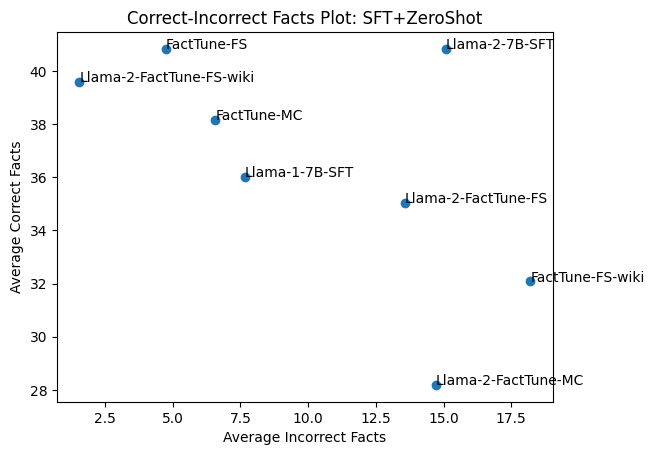

In [59]:
print("""Rangi Te Kanawa was a New Zealand M\u0101ori leader and politician. He was born in 1850 in the Bay of Islands, and was the son of Te Kanawa and his wife, Te Kahui. He was educated at the Wesleyan Mission School in Auckland, and later became a teacher at the Te Aute College.\n\nIn 1875, Te Kanawa was elected to the New Zealand House of Representatives as the representative for the Bay of Islands electorate. He was re-elected in 1876, and served until 1879. During his time in Parliament, he was a member of the Native Lands Committee.\n\nIn 1881, Te Kanawa was appointed as the Native Lands Commissioner for the Bay of Islands. He held this position until 1885, when he was succeeded by William Preece.\n\nIn 1887, Te Kanawa was appointed as the Native Lands Commissioner for the Northland region. He held this position until 1890, when he was succeeded by William Preece again.""")

Rangi Te Kanawa was a New Zealand Māori leader and politician. He was born in 1850 in the Bay of Islands, and was the son of Te Kanawa and his wife, Te Kahui. He was educated at the Wesleyan Mission School in Auckland, and later became a teacher at the Te Aute College.

In 1875, Te Kanawa was elected to the New Zealand House of Representatives as the representative for the Bay of Islands electorate. He was re-elected in 1876, and served until 1879. During his time in Parliament, he was a member of the Native Lands Committee.

In 1881, Te Kanawa was appointed as the Native Lands Commissioner for the Bay of Islands. He held this position until 1885, when he was succeeded by William Preece.

In 1887, Te Kanawa was appointed as the Native Lands Commissioner for the Northland region. He held this position until 1890, when he was succeeded by William Preece again.
